In [120]:
import pandas as pd
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import os
import sys
import utils
pd.set_option('max_columns', 200)
pd.set_option('max_rows', 200)

### 金利featureを見てみる

In [121]:
df = utils.read_df_pkl('../eda/1024_*')
df


100%|██████████| 3/3 [00:00<00:00,  6.10it/s]


,SK_ID_CURR,SK_ID_PREV,DAYS_DECISION,AMT_CREDIT,AMT_ANNUITY,CNT_PAYMENT,AMT_DOWN_PAYMENT,NAME_CONTRACT_TYPE,TARGET,ir_6,ir_9,ir_12,ir_15,ir_18,ir_21,ir_24,ir_27,ir_30,ir_33,ir_36,ir_39,ir_42,ir_45,ir_48,ir_max,ir_min,ir_std
0,271877,2030495,-73.0,17145.0,1730.430,12.0,NaN,Consumer loans,0,NaN,NaN,0.211150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.211150,0.211150,NaN
1,271877,1696966,-472.0,1754721.0,68258.655,36.0,180000.000,Consumer loans,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.167000,NaN,NaN,NaN,NaN,NaN,NaN,0.167000,0.167000,NaN
2,271877,2154916,-548.0,119848.5,12417.390,12.0,NaN,Consumer loans,0,NaN,NaN,0.243309,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.243309,0.243309,NaN
3,108129,2802425,-164.0,679671.0,25188.615,36.0,NaN,Cash loans,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.111800,0.222980,NaN,NaN,NaN,NaN,NaN,0.222980,0.111800,0.078616
4,108129,1536272,-515.0,512370.0,21709.125,36.0,NaN,Cash loans,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.143990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.143990,0.143990,NaN
5,108129,2068863,-619.0,23688.0,4830.930,6.0,24750.000,Consumer loans,0,0.223640,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.223640,0.223640,NaN
6,108129,2551979,-1208.0,71352.0,6664.275,12.0,NaN,Consumer loans,0,NaN,NaN,0.120800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.120800,0.120800,NaN
8,108129,1760610,-819.0,33052.5,8593.965,4.0,NaN,Consumer loans,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,122040,2523466,-301.0,136444.5,15060.735,12.0,NaN,Cash loans,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,122040,2228885,-2576.0,64341.0,7508.610,12.0,NaN,Consumer loans,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 金利発生が半年単位 or 1年単位だけど支払が2ヵ月に1回？と思われる金利featureをTrainとTestで可視化してみる。
#### 傾向を見る為、10日単位の平均をとってプロットする

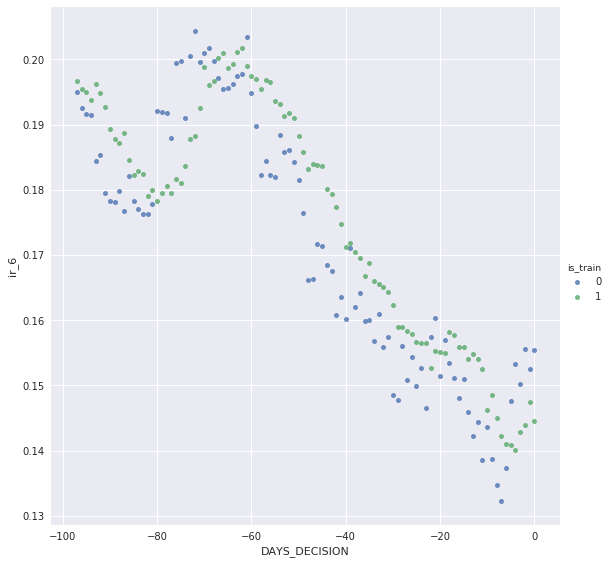

In [127]:
target = 'TARGET'
col = 'ir_6'
dd = 'DAYS_DECISION'

viz = df[~df[col].isnull()].copy()
viz[dd] = (viz[dd]/30).astype('int')
train = viz[viz[target]>=0]
train = train.groupby(dd)[col].mean().reset_index()

train['is_train'] = 1

test = viz[viz[target]==-1]
test = test.groupby(dd)[col].mean().reset_index()

test['is_train'] = 0
viz = pd.concat([train, test], axis=0)
sns.lmplot(x="DAYS_DECISION",y=col, data=viz, fit_reg=False, hue='is_train', size=8, scatter_kws={'s':25})

#### ↑ TrainとTestで5~7か月程度の周期のズレが見える=TrainとTestはデータセットが生成されたタイミングが異なる。
### TrainとTestの時系列のズレを標準化で最小限にする

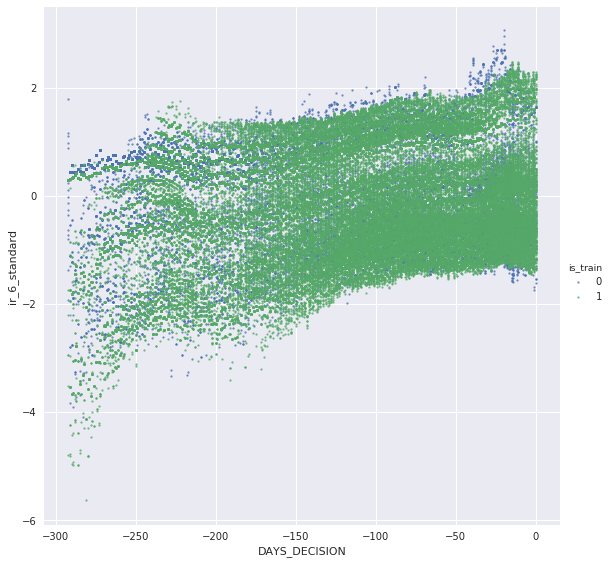

In [128]:
target = 'TARGET'
col = 'ir_6'
dd = 'DAYS_DECISION'

viz = df[~df[col].isnull()].copy()
viz[dd] = (viz[dd]/10).astype('int')
train = viz[viz[target]>=0]

train_mean = train.groupby(dd)[col].mean().reset_index().rename(columns={col:f'{col}_mean'})
train_std = train.groupby(dd)[col].std().reset_index().rename(columns={col:f'{col}_std'})
train = train.merge(train_mean, on=dd, how='inner').merge(train_std, on=dd, how='inner')
train[f'{col}_standard'] = train[[col, f'{col}_mean', f'{col}_std']].apply(lambda x: (x[0]-x[1])/x[2] , axis=1)

train['is_train'] = 1

test = viz[viz[target]==-1]

test_mean = test.groupby(dd)[col].mean().reset_index().rename(columns={col:f'{col}_mean'})
test_std = test.groupby(dd)[col].std().reset_index().rename(columns={col:f'{col}_std'})
test = test.merge(test_mean, on=dd, how='inner').merge(test_std, on=dd, how='inner')
test[f'{col}_standard'] = test[[col, f'{col}_mean', f'{col}_std']].apply(lambda x: (x[0]-x[1])/x[2] , axis=1)

test['is_train'] = 0

viz = pd.concat([train, test], axis=0)
sns.lmplot(x="DAYS_DECISION",y=f'{col}_standard',data=viz,fit_reg=False, hue='is_train', size=8, scatter_kws={'s':5})